In [1]:
%matplotlib inline


# Forward Simulation with User-Defined Waveform on a Tree Mesh

Here we use the module *SimPEG.electromagnetics.time_domain* to predict the
TDEM response for a trapezoidal waveform. We consider an airborne survey
which uses a horizontal coplanar geometry. For this tutorial, we focus
on the following:

    - How to define the transmitters and receivers
    - How to define more complicated transmitter waveforms
    - How to define the time-stepping
    - How to define the survey
    - How to solve TDEM problems on an OcTree mesh
    - How to include topography
    - The units of the conductivity model and resulting data


Please note that we have used a coarse mesh and larger time-stepping to shorten
the time of the simulation. Proper discretization in space and time is required
to simulate the fields at each time channel with sufficient accuracy.


## Import Modules




In [2]:
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

save_file = False

# sphinx_gallery_thumbnail_number = 3

## Defining Topography

Here we define surface topography as an (N, 3) numpy array. Topography could
also be loaded from a file. Here we define flat topography, however more
complex topographies can be considered.




In [3]:
xx, yy = np.meshgrid(np.linspace(-3000, 3000, 101), np.linspace(-3000, 3000, 101))
zz = np.zeros(np.shape(xx))
topo_xyz = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

## Defining the Waveform

Under *SimPEG.electromagnetic.time_domain.sources*
there are a multitude of waveforms that can be defined (VTEM, Ramp-off etc...).
Here, we consider a trapezoidal waveform, which consists of a
linear ramp-on followed by a linear ramp-off. For each waveform, it
is important you are cognizant of the off time!!!




Text(0.5, 1.0, 'Waveform')

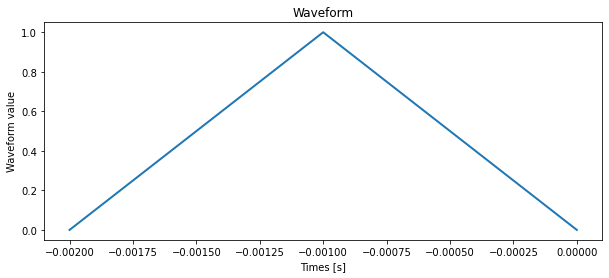

In [4]:
# Define a discrete set of times for which your transmitter is 'on'. Here
# the waveform is on from -0.002 s to 0 s.
waveform_times = np.linspace(-0.002, 0, 21)

# For each waveform type, you must define the necessary set of kwargs.
# For the trapezoidal waveform we define the ramp on interval, the
# ramp-off interval and the off-time.
waveform = tdem.sources.TrapezoidWaveform(
    ramp_on=np.r_[-0.002, -0.001], ramp_off=np.r_[-0.001, 0.0], offTime=0.0
)

# Uncomment to try a quarter sine wave ramp on, followed by a linear ramp-off.
# waveform = tdem.sources.QuarterSineRampOnWaveform(
#     ramp_on=np.r_[-0.002, -0.001],  ramp_off=np.r_[-0.001, 0.], offTime=0.
# )

# Uncomment to try a custom waveform (just a linear ramp-off). This requires
# defining a function for your waveform.
# def wave_function(t):
#     return - t/(np.max(waveform_times) - np.min(waveform_times))
#
# waveform = tdem.sources.RawWaveform(waveFct=wave_function, offTime=0.)

# Evaluate the waveform for each on time.
waveform_value = [waveform.eval(t) for t in waveform_times]

# Plot the waveform
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
ax1.plot(waveform_times, waveform_value, lw=2)
ax1.set_xlabel("Times [s]")
ax1.set_ylabel("Waveform value")
ax1.set_title("Waveform")

## Create Airborne Survey

Here we define the survey used in our simulation. For time domain
simulations, we must define the geometry of the source and its waveform. For
the receivers, we define their geometry, the type of field they measure and
the time channels at which they measure the field. For this example,
the survey consists of a uniform grid of airborne measurements.




In [5]:
# Observation times for response (time channels)
n_times = 3
time_channels = np.logspace(-4, -3, n_times)

# Defining transmitter locations
n_tx = 11
xtx, ytx, ztx = np.meshgrid(
    np.linspace(-200, 200, n_tx), np.linspace(-200, 200, n_tx), [50]
)
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(
    np.linspace(-200, 200, n_tx), np.linspace(-190, 190, n_tx), [30]
)
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location defines a new transmitter
for ii in range(ntx):

    # Here we define receivers that measure the h-field in A/m
    dbzdt_receiver = tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_locations[ii, :], time_channels, "z"
    )
    receivers_list = [
        dbzdt_receiver
    ]  # Make a list containing all receivers even if just one

    # Must define the transmitter properties and associated receivers
    source_list.append(
        tdem.sources.MagDipole(
            receivers_list,
            location=source_locations[ii],
            waveform=waveform,
            moment=1.0,
            orientation="z",
        )
    )

survey = tdem.Survey(source_list)

## Create OcTree Mesh

Here we define the OcTree mesh that is used for this example.
We chose to design a coarser mesh to decrease the run time.
When designing a mesh to solve practical time domain problems:

    - Your smallest cell size should be 10%-20% the size of your smallest diffusion distance
    - The thickness of your padding needs to be 2-3 times biggest than your largest diffusion distance
    - The diffusion distance is ~1260*np.sqrt(rho*t)





In [6]:
dh = 25.0  # base cell width
dom_width = 1600.0  # domain width
nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

# Define the base mesh
h = [(dh, nbc)]
mesh = TreeMesh([h, h, h], x0="CCC")

# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, topo_xyz, octree_levels=[0, 0, 0, 1], method="surface", finalize=False
)

# Mesh refinement near transmitters and receivers
mesh = refine_tree_xyz(
    mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
)

# Refine core mesh region
xp, yp, zp = np.meshgrid([-250.0, 250.0], [-250.0, 250.0], [-250.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2, 4], method="box", finalize=False)

mesh.finalize()

## Create Conductivity Model and Mapping for OcTree Mesh

Here, we define the electrical properties of the Earth as a conductivity
model. The model consists of a conductive block within a more
resistive background.




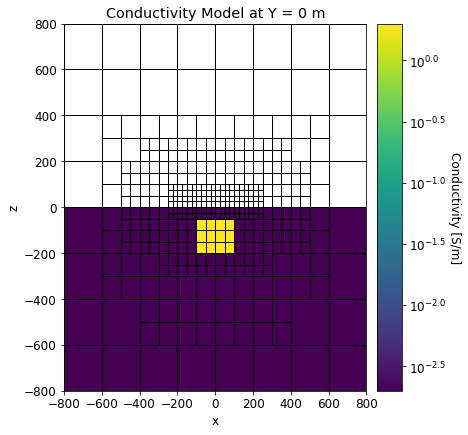

In [7]:
# Conductivity in S/m
air_conductivity = 1e-8
background_conductivity = 2e-3
block_conductivity = 2e0

# Active cells are cells below the surface.
ind_active = surface2ind_topo(mesh, topo_xyz)
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define the model
model = background_conductivity * np.ones(ind_active.sum())
ind_block = (
    (mesh.gridCC[ind_active, 0] < 100.0)
    & (mesh.gridCC[ind_active, 0] > -100.0)
    & (mesh.gridCC[ind_active, 1] < 100.0)
    & (mesh.gridCC[ind_active, 1] > -100.0)
    & (mesh.gridCC[ind_active, 2] > -200.0)
    & (mesh.gridCC[ind_active, 2] < -50.0)
)
model[ind_block] = block_conductivity

# Plot log-conductivity model
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 6))

log_model = np.log10(model)

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.13, 0.1, 0.6, 0.85])
mesh.plotSlice(
    plotting_map * log_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.hx.size / 2),
    grid=True,
    clim=(np.min(log_model), np.max(log_model)),
)
ax1.set_title("Conductivity Model at Y = 0 m")

ax2 = fig.add_axes([0.75, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(vmin=np.min(log_model), vmax=np.max(log_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Define the Time-Stepping

Stuff about time-stepping and some rule of thumb




In [8]:
time_steps = [(1e-4, 20), (1e-5, 10), (1e-4, 10)]

## Simulation: Time-Domain Response

Here we define the formulation for solving Maxwell's equations. Since we are
measuring the time-derivative of the magnetic flux density and working with
a resistivity model, the EB formulation is the most natural. We must also
remember to define the mapping for the conductivity model.
We defined a waveform 'on-time' is from -0.002 s to 0 s. As a result, we need
to set the start time for the simulation to be at -0.002 s.




In [9]:
simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=model_map, Solver=Solver, t0=-0.002
)

# Set the time-stepping for the simulation
simulation.time_steps = time_steps

## Predict Data and Plot




In [10]:
# Predict data for a given model
dpred = simulation.dpred(model)

In [11]:
# Data were organized by location, then by time channel
dpred_plotting = np.reshape(dpred, (n_tx ** 2, n_times))

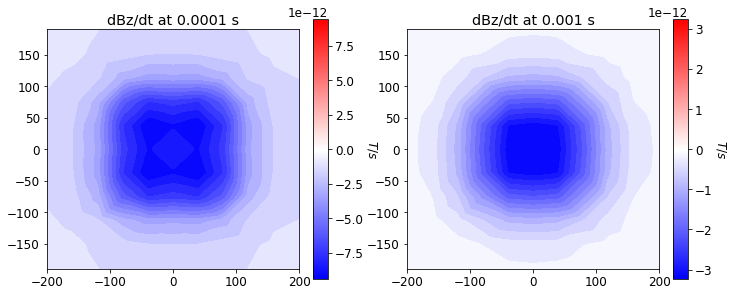

In [12]:
# Plot
fig = plt.figure(figsize=(10, 4))

# dB/dt at early time
v_max = np.max(np.abs(dpred_plotting[:, 0]))
ax11 = fig.add_axes([0.05, 0.05, 0.35, 0.9])
plot2Ddata(
    receiver_locations[:, 0:2],
    dpred_plotting[:, 0],
    ax=ax11,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax11.set_title("dBz/dt at 0.0001 s")

ax12 = fig.add_axes([0.42, 0.05, 0.02, 0.9])
norm1 = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar1 = mpl.colorbar.ColorbarBase(
    ax12, norm=norm1, orientation="vertical", cmap=mpl.cm.bwr
)
cbar1.set_label("$T/s$", rotation=270, labelpad=15, size=12)

# dB/dt at later times
v_max = np.max(np.abs(dpred_plotting[:, -1]))
ax21 = fig.add_axes([0.55, 0.05, 0.35, 0.9])
plot2Ddata(
    receiver_locations[:, 0:2],
    dpred_plotting[:, -1],
    ax=ax21,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax21.set_title("dBz/dt at 0.001 s")

ax22 = fig.add_axes([0.92, 0.05, 0.02, 0.9])
norm2 = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar2 = mpl.colorbar.ColorbarBase(
    ax22, norm=norm2, orientation="vertical", cmap=mpl.cm.bwr
)
cbar2.set_label("$T/s$", rotation=270, labelpad=15, size=12)

plt.show()

## Optional: Export Data

Write the true model, data and topography


